# Master's Thesis Analysis

Predicting discharge times of patients??

#### Author: Derek Lee

## Load Requisite Libraries and authenticate to local Postgres database

In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
import time
import psutil
import numpy as np
import multiprocessing as mp

from sklearn.model_selection import train_test_split



In [2]:
# Check the number of cores and memory usage
num_cores = mp.cpu_count()
print("This kernel has ",num_cores,"cores and you can find the information regarding the memory usage:",psutil.virtual_memory())

This kernel has  8 cores and you can find the information regarding the memory usage: svmem(total=17179869184, available=7139704832, percent=58.4, used=9234681856, free=711114752, active=6423097344, inactive=6198931456, wired=2811584512)


In [3]:
%reload_ext sql
from sqlalchemy import create_engine

In [4]:
import json
json_file = open("secrets.json")
variables = json.load(json_file)
json_file.close()

import os
os.environ['POSTGRES_USERNAME'] = variables['POSTGRES_USERNAME']
os.environ['POSTGRES_PASSWORD'] = variables['POSTGRES_PASSWORD']
os.environ['POSTGRES_ADDRESS'] = variables['POSTGRES_ADDRESS']
os.environ['POSTGRES_PORT'] = variables['POSTGRES_PORT']
os.environ['POSTGRES_DBNAME'] = variables['POSTGRES_DBNAME']

In [5]:
# A long string that contains the necessary Postgres login information 
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=os.getenv('POSTGRES_USERNAME'),
                        password=os.getenv('POSTGRES_PASSWORD'),
                        ipaddress=os.getenv('POSTGRES_ADDRESS'),
                        port=os.getenv('POSTGRES_PORT'),
                        dbname=os.getenv('POSTGRES_DBNAME'))) 
# Create the connection 
engine = create_engine(postgres_str)

-------------------------------------

### Note: Large Dataset:
Running below will take about 5 minutes because it's a dataset with approx 20 million rows

Update: cleaned the data further in sql, reducine our dataset to 3328 rows for 785 unique patients and taking 14 seconds to upload. Seems like tons of duplicate rows, which we removed to get a dataset of 3300 rows ish and 785 unique patients

In [6]:
# Use "postgres -D /usr/local/var/postgres" if the postgres database ever is shut down incorrectly therefore you can't connect


from datetime import datetime 

start_time = datetime.now() 

import time

data = pd.read_sql('''SELECT * FROM public."thesis_data";''', con=engine)


# data = pd.read_sql('''SELECT * FROM public."thesis_data";''', con=engine, chunksize=1000000)


print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:00:07.809192


In [7]:
data.columns


Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'submit_wardid', 'submit_careunit',
       'curr_wardid', 'curr_careunit', 'callout_wardid', 'callout_service',
       'request_cdiff', 'request_mrsa', 'callout_status', 'callout_outcome',
       'discharge_wardid', 'acknowledge_status', 'createtime', 'updatetime',
       'acknowledgetime', 'outcometime', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los', 'costcenter',
       'cpt_cd', 'cpt_number', 'cpt_suffix', 'sectionheader',
       'subsectionheader', 'description', 'transfertime', 'prev_service',
       'curr_service', 'seq_num', 'icd9_code'],

`admittime` = time admitted to hospital  
`dischtime` = time discharged from hospital  
`edregtime` = time registered in ED  
`edouttime` = time discharge from ED    
`createtime` = time and date that the call out was initiated  
`updatetime` = last time at which the call out event was updated  
`acknowledgetime` = time at which the call out was first acknowledged  
`outcometime` = time at which the CALLOUT_OUTCOME occurred  
`intime` = provides the date and time the patient was transferred into the ICU  
`outtime` = provides the date and time the patient was transferred out of the ICU  
`los` = length of stay for the patient for the given ICU stay, which may include one or more ICU units. The length of stay is measured in fractional days.


Most variables are categorical, some being text while others are number codes. For the times, we can convert into cyclical time features https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/ so it becomes continuous.

In [8]:
data.shape

(3328, 60)

In [188]:
data[['subject_id','intime','createtime', 'updatetime', 'acknowledgetime', 'transfertime' , 'outtime', 'prev_service']].head(20)

,subject_id,intime,createtime,updatetime,acknowledgetime,transfertime,outtime,prev_service
0,160,2174-11-06 10:07:03,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-06 08:38:58,2174-11-07 22:37:53,None
1,160,2174-11-06 10:07:03,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-06 08:38:58,2174-11-07 22:37:53,None
2,160,2174-11-06 10:07:03,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-06 08:38:58,2174-11-07 22:37:53,None
3,160,2174-11-06 10:07:03,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-06 08:38:58,2174-11-07 22:37:53,None
4,160,2174-11-06 10:07:03,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-06 08:38:58,2174-11-07 22:37:53,None
5,160,2174-11-06 10:07:03,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-06 08:38:58,2174-11-07 22:37:53,None
6,160,2174-11-06 10:07:03,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-06 08:38:58,2174-11-07 22:37:53,None
7,197,2174-03-23 00:34:45,2174-03-23 15:46:47,2174-03-23 15:46:47,NaT,2174-03-22 19:48:19,2174-03-23 20:24:29,None
8,197,2174-03-23 00:34:45,2174-03-23 15:46:47,2174-03-23 15:46:47,NaT,2174-03-22 19:48:19,2174-03-23 20:24:29,None
9,262,2153-09-25 18:02:24,2153-09-27 12:58:24,2153-09-27 12:58:24,NaT,2153-09-25 18:02:24,2153-09-27 13:59:18,None


In [191]:
pd.set_option('display.max_columns', None)
data[data['subject_id']==160]

# difference between rows is the seq_num and the icd9_code



,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,submit_wardid,submit_careunit,curr_wardid,curr_careunit,callout_wardid,callout_service,request_cdiff,request_mrsa,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,costcenter,cpt_cd,cpt_number,cpt_suffix,sectionheader,subsectionheader,description,transfertime,prev_service,curr_service,seq_num,icd9_code,timediff,timediff_hours
0,F,2124-11-22,NaT,NaT,NaT,0,214,160,161672,2174-11-06 08:38:00,2174-11-08 16:35:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,None,WHITE,2174-11-06 08:19:00,2174-11-06 08:39:00,ST ELEVATION MI,0,1,7,None,17,CCU,17,CCU,0,0,Inactive,Discharged,17.0,Revised,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-07 22:55:02,CCU,CCU,7,7,2174-11-06 10:07:03,2174-11-07 22:37:53,1.5214,ICU,99291,99291,None,Evaluation and management,Critical care services,None,2174-11-06 08:38:58,None,CMED,1,0066,1 days 12:30:50,12.5
1,F,2124-11-22,NaT,NaT,NaT,0,214,160,161672,2174-11-06 08:38:00,2174-11-08 16:35:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,None,WHITE,2174-11-06 08:19:00,2174-11-06 08:39:00,ST ELEVATION MI,0,1,7,None,17,CCU,17,CCU,0,0,Inactive,Discharged,17.0,Revised,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-07 22:55:02,CCU,CCU,7,7,2174-11-06 10:07:03,2174-11-07 22:37:53,1.5214,ICU,99291,99291,None,Evaluation and management,Critical care services,None,2174-11-06 08:38:58,None,CMED,2,3606,1 days 12:30:50,12.5
2,F,2124-11-22,NaT,NaT,NaT,0,214,160,161672,2174-11-06 08:38:00,2174-11-08 16:35:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,None,WHITE,2174-11-06 08:19:00,2174-11-06 08:39:00,ST ELEVATION MI,0,1,7,None,17,CCU,17,CCU,0,0,Inactive,Discharged,17.0,Revised,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-07 22:55:02,CCU,CCU,7,7,2174-11-06 10:07:03,2174-11-07 22:37:53,1.5214,ICU,99291,99291,None,Evaluation and management,Critical care services,None,2174-11-06 08:38:58,None,CMED,3,3723,1 days 12:30:50,12.5
3,F,2124-11-22,NaT,NaT,NaT,0,214,160,161672,2174-11-06 08:38:00,2174-11-08 16:35:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,None,WHITE,2174-11-06 08:19:00,2174-11-06 08:39:00,ST ELEVATION MI,0,1,7,None,17,CCU,17,CCU,0,0,Inactive,Discharged,17.0,Revised,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-07 22:55:02,CCU,CCU,7,7,2174-11-06 10:07:03,2174-11-07 22:37:53,1.5214,ICU,99291,99291,None,Evaluation and management,Critical care services,None,2174-11-06 08:38:58,None,CMED,4,0045,1 days 12:30:50,12.5
4,F,2124-11-22,NaT,NaT,NaT,0,214,160,161672,2174-11-06 08:38:00,2174-11-08 16:35:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,None,WHITE,2174-11-06 08:19:00,2174-11-06 08:39:00,ST ELEVATION MI,0,1,7,None,17,CCU,17,CCU,0,0,Inactive,Discharged,17.0,Revised,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-07 22:55:02,CCU,CCU,7,7,2174-11-06 10:07:03,2174-11-07 22:37:53,1.5214,ICU,99291,99291,None,Evaluation and management,Critical care services,None,2174-11-06 08:38:58,None,CMED,5,0040,1 days 12:30:50,12.5
5,F,2124-11-22,NaT,NaT,NaT,0,214,160,161672,2174-11-06 08:38:00,2174-11-08 16:35:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,None,WHITE,2174-11-06 08:19:00,2174-11-06 08:39:00,ST ELEVATION MI,0,1,7,None,17,CCU,17,CCU,0,0,Inactive,Discharged,17.0,Revised,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-07 22:55:02,CCU,CCU,7,7,2174-11-06 10:07:03,2174-11-07 22:37:53,1.5214,ICU,99291,99291,None,Evaluation and management,Critical care services,None,2174-11-06 08:38:58,None,CMED,6,8856,1 days 12:30:50,12.5
6,F,2124-11-22,NaT,NaT,NaT,0,214,160,161672

In [200]:
data[data['acknowledgetime'].isna()==False].head(40)

,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,submit_wardid,submit_careunit,curr_wardid,curr_careunit,callout_wardid,callout_service,request_cdiff,request_mrsa,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,costcenter,cpt_cd,cpt_number,cpt_suffix,sectionheader,subsectionheader,description,transfertime,prev_service,curr_service,seq_num,icd9_code,timediff,timediff_hours
14,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.8310,ICU,99253,99253,None,Evaluation and management,Consultations,None,2176-04-10 20:46:09,None,VSURG,1,8411,1 days 19:56:38,19.9
15,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.8310,Resp,94002,94002,None,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)",2176-04-10 20:46:09,None,VSURG,1,8411,1 days 19:56:38,19.9
16,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,ICU,47130,47130,None,Surgery,Digestive system,None,2190-01-05 00:37:59,None,SURG,1,527,2 days 21:40:10,21.7
17,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,Resp,94003,94003,None,Medicine,Pulmonary,VENT MGMT;SUBSQ DAYS(INVASIVE),2190-01-05 00:37:59,None,SURG,1,527,2 days 21:40:10,21.7
18,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,ICU,47130,47130,None,Surgery,Digestive system,None,2190-01-05 00:37:59,None,SURG,2,5122,2 days 21:40:10,21.7
19,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,Resp,94003,94003,None,Medicine,Pulmonary

In [195]:
data.admission_location.unique()

array(['EMERGENCY ROOM ADMIT', 'PHYS REFERRAL/NORMAL DELI',
       'TRANSFER FROM HOSP/EXTRAM', 'CLINIC REFERRAL/PREMATURE'],
      dtype=object)

In [196]:
data.discharge_location.unique()

array(['HOME', 'REHAB/DISTINCT PART HOSP', 'HOME HEALTH CARE',
       'DISCH-TRAN TO PSYCH HOSP', 'SNF', 'LEFT AGAINST MEDICAL ADVI',
       'SHORT TERM HOSPITAL', 'DISC-TRAN CANCER/CHLDRN H', 'DEAD/EXPIRED',
       'HOME WITH HOME IV PROVIDR', 'LONG TERM CARE HOSPITAL'],
      dtype=object)

In [194]:
data.description.unique()

array([None, 'VENT MGMT, 1ST DAY (INVASIVE)',
       'VENT MGMT;SUBSQ DAYS(INVASIVE)', 'VENT MGMT;SUBSQ DAYS(NIV)',
       'VENT MGMT,1ST DAY (NIV)'], dtype=object)

In [193]:
data.diagnosis.unique()

array(['ST ELEVATION MI',
       'EXPLORATORY LAPAROTOMY FOR SMALL BOWEL OBSTRUCTION',
       'HYPERTROPHIC CARDIOMYOPATHY\\ETHANOL SEPTAL ABLATION/SDA',
       'INFECTED RIGHT FOOT', 'METASTATIC PANCREATIC CA/SDA',
       'VENTRAL HERNIA/SDA',
       'CAD, MR\\CORONARY ARTERY BYPASS GRAFT;MITRAL VALVE REPLACEMENT/SDA',
       'CORONARY ARTERY DISEASE',
       'CORONARY ARTERY DISEASE;HYPERTENSION\\CATH',
       'ATRIAL SEPTAL DEFECT;PATENT FORAMEN OVALE\\MINIMALLY INVASIVE PATENT FORAMEN OVALE ',
       'PAROXYSMAL ATRIAL AFRIBILLATION\\MITRAL VALVE REPLACEMENT (FULL MAZE) /SDA',
       'SUBDURAL HEMORRHAGE', 'MR\\MITRAL VALVE REPLACEMENT /SDA',
       'MR\\MITRAL VALVE REPLACEMENT; ? CORONARY ARTERY BYPASS GRAFT ',
       'ATRIAL FIBRILLATION\\ATRIAL FIBRILLATION ABLATION',
       'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT /SDA',
       'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT/SDA',
       'ANTERIOR MEDIASTINAL MASS/SDA',
       'ASCENDING SINUS VENUS\\ REPA

#### Creating the target variable:

Our target variable is the time it takes from when a person is ready for discharge to when they are actually discharged. This needs to be engineered from our data.

In [208]:
# data['timediff'] = data['outtime']-data['intime']


data['timediff'] = data['outcometime']-data['acknowledgetime']

In [216]:
data[data['timediff'].isna()==False] # success!

,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,submit_wardid,submit_careunit,curr_wardid,curr_careunit,callout_wardid,callout_service,request_cdiff,request_mrsa,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,costcenter,cpt_cd,cpt_number,cpt_suffix,sectionheader,subsectionheader,description,transfertime,prev_service,curr_service,seq_num,icd9_code,timediff,timediff_hours
14,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.8310,ICU,99253,99253,None,Evaluation and management,Consultations,None,2176-04-10 20:46:09,None,VSURG,1,8411,1 days 04:54:32,19.9
15,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.8310,Resp,94002,94002,None,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)",2176-04-10 20:46:09,None,VSURG,1,8411,1 days 04:54:32,19.9
16,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,ICU,47130,47130,None,Surgery,Digestive system,None,2190-01-05 00:37:59,None,SURG,1,527,1 days 08:29:33,21.7
17,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,Resp,94003,94003,None,Medicine,Pulmonary,VENT MGMT;SUBSQ DAYS(INVASIVE),2190-01-05 00:37:59,None,SURG,1,527,1 days 08:29:33,21.7
18,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,ICU,47130,47130,None,Surgery,Digestive system,None,2190-01-05 00:37:59,None,SURG,2,5122,1 days 08:29:33,21.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,F,2055-07-17,2144-01-23,NaT,2144-01-23,1,58917,99814,186518,2142-02-16 16:33:00,2142-02-21 16:38:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,SNF,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,NaT,NaT,TRANSIENT ISCHEMIC ATTACK,

In [217]:
data[data['subject_id']==286]

,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,submit_wardid,submit_careunit,curr_wardid,curr_careunit,callout_wardid,callout_service,request_cdiff,request_mrsa,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,costcenter,cpt_cd,cpt_number,cpt_suffix,sectionheader,subsectionheader,description,transfertime,prev_service,curr_service,seq_num,icd9_code,timediff,timediff_hours
14,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.831,ICU,99253,99253,None,Evaluation and management,Consultations,None,2176-04-10 20:46:09,None,VSURG,1,8411,1 days 04:54:32,19.9
15,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.831,Resp,94002,94002,None,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)",2176-04-10 20:46:09,None,VSURG,1,8411,1 days 04:54:32,19.9


In [219]:
timediff_noNA = data[data['timediff'].isna()==False]

timediff_noNA.drop_duplicates(subset=['subject_id','diagnosis'], keep='last')

,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,submit_wardid,submit_careunit,curr_wardid,curr_careunit,callout_wardid,callout_service,request_cdiff,request_mrsa,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,costcenter,cpt_cd,cpt_number,cpt_suffix,sectionheader,subsectionheader,description,transfertime,prev_service,curr_service,seq_num,icd9_code,timediff,timediff_hours
15,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.8310,Resp,94002,94002,None,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)",2176-04-10 20:46:09,None,VSURG,1,8411,1 days 04:54:32,19.9
25,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,Resp,94003,94003,None,Medicine,Pulmonary,VENT MGMT;SUBSQ DAYS(INVASIVE),2190-01-05 00:37:59,None,SURG,5,9907,1 days 08:29:33,21.7
27,F,2091-05-22,2171-11-14,NaT,2171-11-14,1,543,423,128697,2171-03-29 07:15:00,2171-04-03 14:54:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,NaT,NaT,VENTRAL HERNIA/SDA,0,1,33,None,40,SICU,40,SURG,0,0,Inactive,Discharged,40.0,Acknowledged,2171-03-31 09:11:40,2171-03-31 09:11:40,2171-03-31 10:22:30,2171-03-31 13:25:03,SICU,SICU,33,33,2171-03-30 12:48:57,2171-03-31 13:12:22,1.0163,ICU,99254,99254,None,Evaluation and management,Consultations,None,2171-03-29 02:49:36,None,SURG,2,5794,0 days 03:02:33,0.4
37,M,2088-11-09,2160-02-03,NaT,2160-02-03,1,567,443,145041,2159-09-24 11:30:00,2159-10-05 14:45:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,REHAB/DISTINCT PART HOSP,Medicare,None,NOT SPECIFIED,SINGLE,WHITE,NaT,NaT,"CAD, MR\CORONARY ARTERY BYPASS GRAFT;MITRAL VA...",0,1,14,None,55,CSRU,55,CSURG,0,0,Inactive,Discharged,55.0,Acknowledged,2159-09-27 12:39:09,2159-09-27 12:39:09,2159-09-27 12:56:32,2159-09-28 09:40:07,CSRU,CSRU,14,14,2159-09-25 07:04:39,2159-09-28 09:16:44,3.0917,Resp,94002,94002,None,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)",2159-09-24 00:53:08,None,CSURG,5,9904,0 days 20:43:35,2.2
41,F,2129-12-24,NaT,NaT,NaT,0,611,485,116665,2195-02-18 18:25:00,2195-02-25 16:20:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Private,None,PROTESTANT QUAKER,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE,0,1,12,None,55,CSRU,55,CSURG,0,0,Inactive,Discharged,55.0,Acknowledged,2195-02-21 09:43:13,2195-02-21 09:43:13,2195-02-21 10:39:21,2195-02-22 17:10:02,CSRU,CSRU,12,12,2195-02-19 15:08:52,2195-02-22 16:59:50,3.0771,Resp,94002,94002,None,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)",2195-02-18 18:27:32,None,CSURG,4,9904,1 days 06:30:41,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,M,2033-01-19,2118-10-05,2118-10-05,2118-10-05,1,58488,98481,152219,2118-05-28 15:01:00,2118-06-03 15:39:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATUR

In [220]:
min(timediff_noNA.timediff)
max(timediff_noNA.timediff)
(timediff_noNA.timediff).mean()

Timedelta('0 days 07:06:50.719309')

-----------------------------------------------------------------------

## Exploratory Data Analysis

In [221]:
timediff_noNA.columns

Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'submit_wardid', 'submit_careunit',
       'curr_wardid', 'curr_careunit', 'callout_wardid', 'callout_service',
       'request_cdiff', 'request_mrsa', 'callout_status', 'callout_outcome',
       'discharge_wardid', 'acknowledge_status', 'createtime', 'updatetime',
       'acknowledgetime', 'outcometime', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los', 'costcenter',
       'cpt_cd', 'cpt_number', 'cpt_suffix', 'sectionheader',
       'subsectionheader', 'description', 'transfertime', 'prev_service',
       'curr_service', 'seq_num', 'icd9_code', 

##### Initial logic checks:

While we deduped the initial dataset, we still have lots to do to inspect and clean our data.  

1) Look to see if data makes sense. Check if there are any patients where their date of death (dod) is before date of birth (dob), is edregtime before edouttime?

2) If there are any of the times that are out of order (besides date of birth), we can flag those as administrative errors  


In [222]:
# data.gender.unique()

from datetime import datetime, timedelta 
# truth = ((data.dod.dt.date-data.dob.dt.date)<timedelta(0))
# truth = ((data.edouttime.dt.date-data.edregtime.dt.date)<timedelta(0))
# truth = ((data.updatetime.dt.date-data.createtime.dt.date)<timedelta(0))
truth = ((timediff_noNA.outtime.dt.date-data.intime.dt.date)<timedelta(0))
truth.unique()



array([False])

It appears that we don't have any errors with the order of times in our data. If we did, we would see some negative values in the subtraction of the two dates and therefore the array would have `True` values.  

We do have issues with the years in the `dob` and `dod` variables corresponding to date of birth and date of death. We may have to discard these as there's no better wage to ascertain age.

In [223]:
sorted(timediff_noNA['dob'].unique())

[numpy.datetime64('1804-03-11T00:00:00.000000000'),
 numpy.datetime64('1813-10-20T00:00:00.000000000'),
 numpy.datetime64('1816-03-20T00:00:00.000000000'),
 numpy.datetime64('1846-08-05T00:00:00.000000000'),
 numpy.datetime64('1850-02-19T00:00:00.000000000'),
 numpy.datetime64('1862-02-03T00:00:00.000000000'),
 numpy.datetime64('1865-03-21T00:00:00.000000000'),
 numpy.datetime64('1867-07-26T00:00:00.000000000'),
 numpy.datetime64('1868-06-22T00:00:00.000000000'),
 numpy.datetime64('1868-07-18T00:00:00.000000000'),
 numpy.datetime64('1870-11-10T00:00:00.000000000'),
 numpy.datetime64('1870-12-31T00:00:00.000000000'),
 numpy.datetime64('1874-10-20T00:00:00.000000000'),
 numpy.datetime64('1878-05-07T00:00:00.000000000'),
 numpy.datetime64('1879-12-20T00:00:00.000000000'),
 numpy.datetime64('1890-02-13T00:00:00.000000000'),
 numpy.datetime64('1900-11-14T00:00:00.000000000'),
 numpy.datetime64('2014-01-01T00:00:00.000000000'),
 numpy.datetime64('2016-11-18T00:00:00.000000000'),
 numpy.datet

##### Check for missing values

In [241]:
# timediff_noNA['dod'].isna().sum() # 2417 people did not die within 90 days post discharge
# timediff_noNA['dod_hosp'].isna().sum() # 2739 people did not die in hospital
# timediff_noNA['dod_ssn'].isna().sum() # 2487 did not die according to social security records
# timediff_noNA['language'].isna().sum() # 919 unknown language
# timediff_noNA['marital_status'].isna().sum() # 120 unknown marital status
# timediff_noNA['edregtime'].isna().sum() # 2231 unknown edregtime, edouttime - likely didn't visit ED
# timediff_noNA['submit_careunit'].isna().sum() # 2846 was not from ICU
# timediff_noNA['discharge_wardid'].isna().sum() # 66 unknown wards to which the patient was discharged.
# timediff_noNA['acknowledgetime'].isna().sum() # 314 did not record acknowledgetime
# timediff_noNA['cpt_suffix'].isna().sum() # 3014 unknown Text element of the Current Procedural Terminology (CPT)
# timediff_noNA['description'].isna().sum()# 1333 missing description of CPT
# timediff_noNA['prev_service'].isna().sum() # 2996 missing previous service type


`expire_flag`, `deathtime` will of course have some missing since it's indicating who died or not

##### Visualizing distributions of our data

Text(0.5, 1.0, 'Distribution of ED registration time by Day of Month')

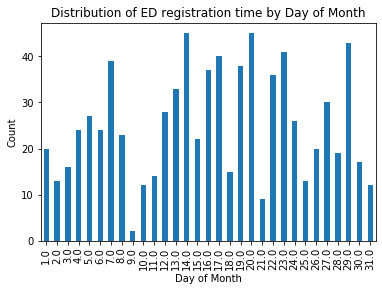

In [242]:
from scipy import stats
import matplotlib.pylab as plt

%matplotlib inline
timediff_noNA["edregtime"].groupby(timediff_noNA["edregtime"].dt.day).count().plot(kind="bar")
# data["edregtime"].groupby(data["edregtime"].dt.day).count().plot.hist(bins=12, alpha= 0.5)
# data["edregtime"].groupby(data["edregtime"].dt.day).count().plot.hist()


plt.xlabel("Day of Month")
plt.ylabel("Count")
plt.title("Distribution of ED registration time by Day of Month")

Text(0.5, 1.0, 'Distribution of ED out time by Day of Month')

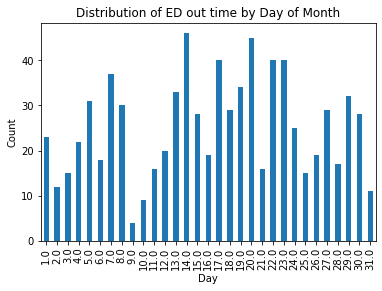

In [243]:
timediff_noNA["edouttime"].groupby(timediff_noNA["edouttime"].dt.day).count().plot(kind="bar")
# data["edouttime"].groupby(data["edouttime"].dt.day).count().plot.hist()
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Distribution of ED out time by Day of Month")

Text(0.5, 1.0, 'Distribution of admit time by Day of Month')

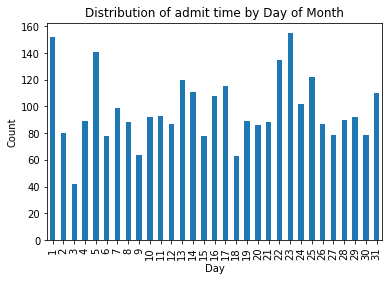

In [244]:
timediff_noNA["admittime"].groupby(timediff_noNA["admittime"].dt.day).count().plot(kind="bar")
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Distribution of admit time by Day of Month")

Text(0.5, 1.0, 'Distribution of discharge time by Day of Month')

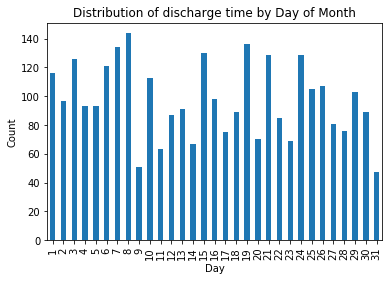

In [245]:
timediff_noNA["dischtime"].groupby(timediff_noNA["dischtime"].dt.day).count().plot(kind="bar")
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Distribution of discharge time by Day of Month")

We may want to create a new variable putting days into week in month (days 1-7, 8-14, 15-21, 22-31)

Text(0.5, 1.0, 'Distribution of discharge time by Month')

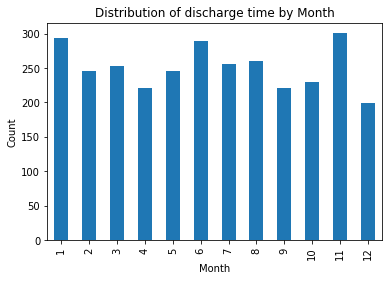

In [246]:
timediff_noNA["dischtime"].groupby(timediff_noNA["dischtime"].dt.month).count().plot(kind="bar")
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Distribution of discharge time by Month")

Text(0.5, 1.0, 'Distribution of discharge time by hour')

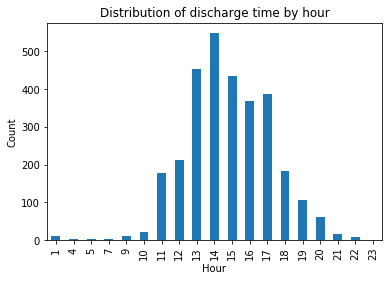

In [247]:
timediff_noNA["dischtime"].groupby(timediff_noNA["dischtime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of discharge time by hour")

Text(0.5, 1.0, 'Distribution of death time by Month')

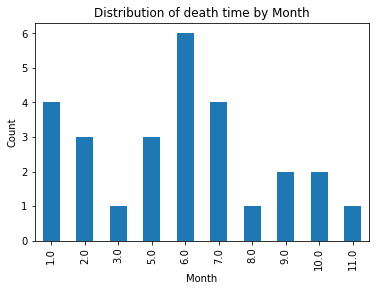

In [248]:
timediff_noNA["deathtime"].groupby(timediff_noNA["deathtime"].dt.month).count().plot(kind="bar")
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Distribution of death time by Month")

Text(0.5, 1.0, 'Distribution of death time by Hour')

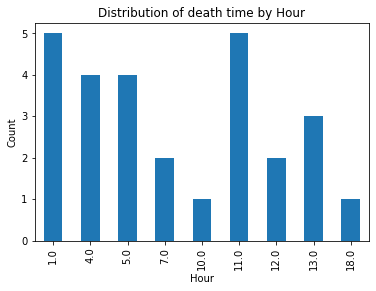

In [249]:
timediff_noNA["deathtime"].groupby(timediff_noNA["deathtime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of death time by Hour")

Text(0.5, 1.0, 'Distribution of create time by hour')

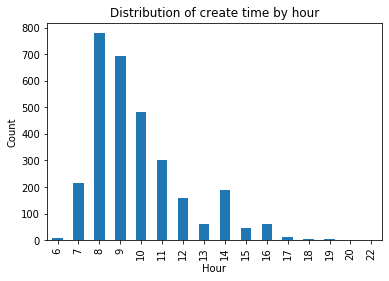

In [250]:
timediff_noNA["createtime"].groupby(timediff_noNA["createtime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of create time by hour")

Text(0.5, 1.0, 'Distribution of update time by hour')

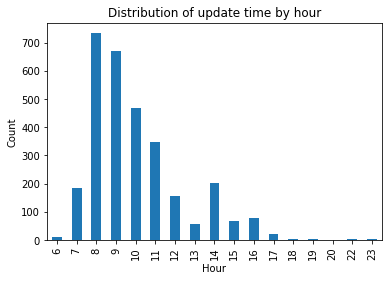

In [251]:
timediff_noNA["updatetime"].groupby(timediff_noNA["updatetime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of update time by hour")

Text(0.5, 1.0, 'Distribution of acknowledge time by hour')

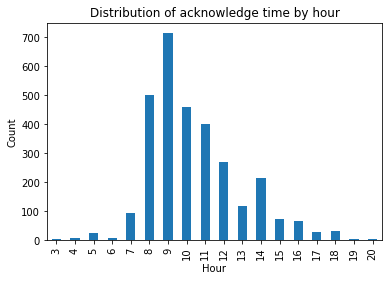

In [252]:
timediff_noNA["acknowledgetime"].groupby(timediff_noNA["acknowledgetime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of acknowledge time by hour")

Text(0.5, 1.0, 'Distribution of outcome time by hour')

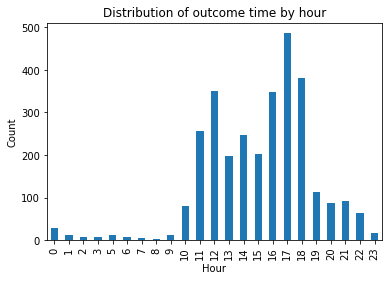

In [253]:
timediff_noNA["outcometime"].groupby(timediff_noNA["outcometime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of outcome time by hour")

Text(0.5, 1.0, 'Distribution of in time by hour')

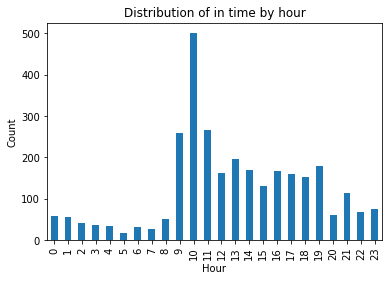

In [254]:
timediff_noNA["intime"].groupby(timediff_noNA["intime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of in time by hour")

Text(0.5, 1.0, 'Distribution of out time by hour')

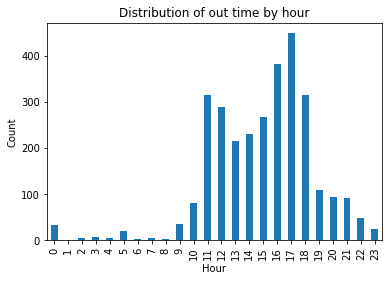

In [255]:
timediff_noNA["outtime"].groupby(timediff_noNA["outtime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of out time by hour")

Text(0.5, 1.0, 'Distribution of transfer time by hour')

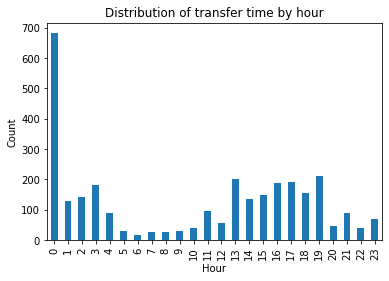

In [256]:
timediff_noNA["transfertime"].groupby(timediff_noNA["transfertime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of transfer time by hour")

The above plots have shown us that there may be some trends with different time events.

When examining the days of the month that certain events happened, we see a lot of visits happen on the same day, meaning that the highest volume of `edregtime` and `edouttime` fall on the same days. In this dataset, they seem to fall overwhelmingly on the 7th, 13th, 14th, 17th, 20th, 22nd, and 29th of the month. The high turnover in emergency departments makes sense. On the other hand, `admittime` and `dischtime` don't necessarily fall on the same day. These are probably describing hospital stays over the course of several days.

Discharge times (`dischtime`) seem to most commonly occur during the afternoon hours from 1-5 pm. `deathtime` seems to be most common at 1 am and between 11 am and 12 pm. There may be some correlation there with how often rounds are made. 

`createtime` and `updatetime` describe call outs, or more specifically, the record of when patients were ready for discharge (called out), and the actual time of their discharge (or more generally, their outcome), as described by `outcometime`. `createtime`, `updatetime`, and `acknowledgetime` occur most frequently from 8 am - 10 am. `outcometime` occurs most frequently from 4 pm to 6 pm. This pattern warrants some further exploration to see truly how long each patient has to wait from when they are ready for discharge to when they are actually discharged.

The services table describes hospital services that patients were under during their hospital stay. `transfertime` describes the time when a transfer occured. The most common transfer time was overwhelmingly 12 am, followed by 1 pm, 3 am and 5 pm (equally common), and 7 pm.  





In [257]:
timediff_noNA.columns

Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'submit_wardid', 'submit_careunit',
       'curr_wardid', 'curr_careunit', 'callout_wardid', 'callout_service',
       'request_cdiff', 'request_mrsa', 'callout_status', 'callout_outcome',
       'discharge_wardid', 'acknowledge_status', 'createtime', 'updatetime',
       'acknowledgetime', 'outcometime', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los', 'costcenter',
       'cpt_cd', 'cpt_number', 'cpt_suffix', 'sectionheader',
       'subsectionheader', 'description', 'transfertime', 'prev_service',
       'curr_service', 'seq_num', 'icd9_code', 

In [258]:
timediff_noNA['description'].unique() # only a few categories for the description so it's not really free text


array([None, 'VENT MGMT, 1ST DAY (INVASIVE)',
       'VENT MGMT;SUBSQ DAYS(INVASIVE)', 'VENT MGMT;SUBSQ DAYS(NIV)',
       'VENT MGMT,1ST DAY (NIV)'], dtype=object)

In [259]:
timediff_noNA['admission_location'].unique()

array(['TRANSFER FROM HOSP/EXTRAM', 'PHYS REFERRAL/NORMAL DELI',
       'EMERGENCY ROOM ADMIT', 'CLINIC REFERRAL/PREMATURE'], dtype=object)

In [260]:
timediff_noNA['admission_type'].unique()

array(['EMERGENCY', 'ELECTIVE', 'URGENT'], dtype=object)

In [261]:
timediff_noNA['discharge_location'].unique()

array(['REHAB/DISTINCT PART HOSP', 'HOME HEALTH CARE', 'HOME',
       'DISCH-TRAN TO PSYCH HOSP', 'SNF', 'LEFT AGAINST MEDICAL ADVI',
       'SHORT TERM HOSPITAL', 'DISC-TRAN CANCER/CHLDRN H', 'DEAD/EXPIRED',
       'LONG TERM CARE HOSPITAL'], dtype=object)

Now we want to make a correlation matrix of our data

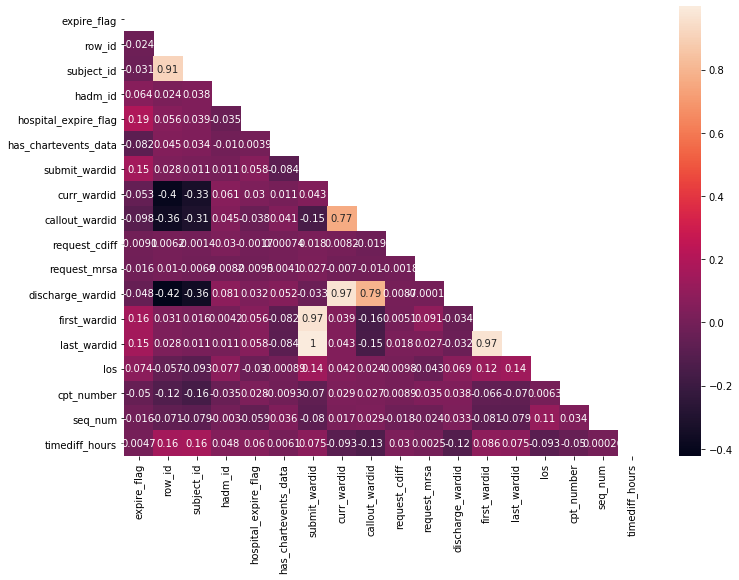

In [262]:
import seaborn as sns
a4_dims = (11.7, 8.27)
corrMatrix=timediff_noNA.corr()
mask_ut=np.triu(np.ones(corrMatrix.shape)).astype(np.bool)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(corrMatrix,mask=mask_ut,annot=True)
plt.show()

Evaluating the correlation matrix, `subject_id` and `row_id` seem to be pretty correlated. `callout_wardid` and `curr_wardid` makes sense they also would be highly correlated. Essentially all the ward_id's seem to be highly correlated so we'll have to deal with those: `first_wardid` and `last_wardid`, `callout_wardid` and `discharge_wardid`, `last_wardid` and `submit_wardid`, `discharge_wardid` and `curr_wardid`, `first_wardid` and `submit_wardid`. Everything else doesn't seem really correlated and negative correlations are all weak.

However, on second thought, these are mostly categorical variables and thus we can't realistically calculate the Pearson's Correlation Coefficient among them.

### ANOVA

In [308]:
timediff_noNA['timediff_hours'] = (timediff_noNA['outtime'].sub(data['intime']).dt.seconds/60/60).round(1)


/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


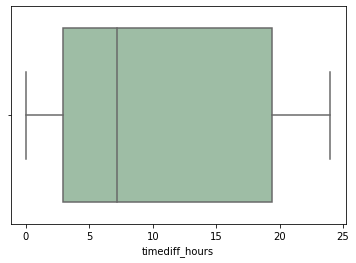

In [265]:
ax = sns.boxplot(timediff_noNA['timediff_hours'], data=timediff_noNA, color='#99c2a2')


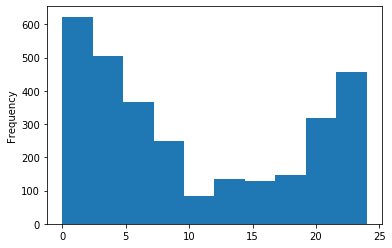

In [266]:
(timediff_noNA['timediff_hours']).plot.hist()

/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


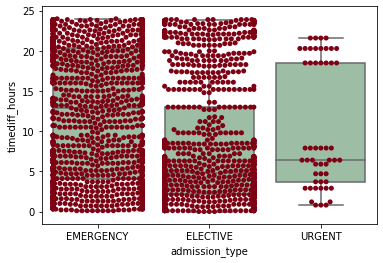

In [267]:
timediff_noNA['timediff_hours'] = (timediff_noNA['outtime'].sub(timediff_noNA['intime']).dt.seconds/60/60).round(1)

ax = sns.boxplot(x='admission_type', y=timediff_noNA['timediff_hours'], data=timediff_noNA, color='#99c2a2')
ax = sns.swarmplot(x="admission_type", y=timediff_noNA['timediff_hours'], data=timediff_noNA, color='#7d0013')
plt.show()



In [268]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


model = ols('timediff_hours ~ C(admission_type)', data=timediff_noNA).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
C(admission_type),13363.683932,2.0,104.961382,8.603683e-45
Residual,191680.270484,3011.0,NaN,NaN


In [269]:
import scikit_posthocs as sp
sp.posthoc_ttest(timediff_noNA, val_col='timediff_hours', group_col='admission_type', p_adjust='holm')

# significant difference between Emergency and Elective only

,EMERGENCY,ELECTIVE,URGENT
EMERGENCY,1.000000e+00,1.745545e-45,0.087832
ELECTIVE,1.745545e-45,1.000000e+00,0.081319
URGENT,8.783171e-02,8.131879e-02,1.000000


Based on these results, we may want to just look at Emergency and Urgent only since Emergency and Elective seem to show a significant difference at the 0.05 significance level. 




In [270]:
timediff_noNA[timediff_noNA['admission_type']=="EMERGENCY"].shape

(1565, 62)

In [271]:
timediff_noNA[timediff_noNA['admission_type']=="ELECTIVE"].shape

(1398, 62)

In [272]:
timediff_noNA[timediff_noNA['admission_type']=="URGENT"].shape

(51, 62)

## Refining dataset

In [275]:
timediff_ER_urgent = timediff_noNA[timediff_noNA['admission_type']!='ELECTIVE']

In [276]:
timediff_ER_urgent.shape

(1616, 62)

In [306]:
# reminder of columns with missing data

timediff_ER_urgent.columns[timediff_ER_urgent.isnull().any()]

Index(['dod', 'dod_hosp', 'dod_ssn', 'deathtime', 'language', 'marital_status',
       'edregtime', 'edouttime', 'submit_careunit', 'discharge_wardid',
       'cpt_suffix', 'description', 'prev_service'],
      dtype='object')

Do we want to eliminate those who died? Probably not.  
What to do about missing language and marital status? Categorize as unknown.  
Missing `submit_careunit`, `discharge_wardid`

## Final Dataset:

In [316]:
timediff_ER_urgent.columns


Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'submit_wardid', 'submit_careunit',
       'curr_wardid', 'curr_careunit', 'callout_wardid', 'callout_service',
       'request_cdiff', 'request_mrsa', 'callout_status', 'callout_outcome',
       'discharge_wardid', 'acknowledge_status', 'createtime', 'updatetime',
       'acknowledgetime', 'outcometime', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los', 'costcenter',
       'cpt_cd', 'cpt_number', 'cpt_suffix', 'sectionheader',
       'subsectionheader', 'description', 'transfertime', 'prev_service',
       'curr_service', 'seq_num', 'icd9_code', 

In [317]:
# using the hours column may help us avoid converting to cyclical time features esp if we don't care about cyclical

X = timediff_ER_urgent.timediff_hours

y = timediff_ER_urgent.loc[:, timediff_ER_urgent.columns != 'timediff_hours']


## Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=42) # n_estimators is no. of trees
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [ ]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


# You can play around with the number of trees and other parameters to see 
# if you can get better results

